In [39]:
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.cluster import DBSCAN
import numpy as np
import scipy as sp

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [29]:
dt = pd.read_excel('CancerSurvivalData.xlsx',engine='openpyxl') # First 3 variables is the nonh cell profile variables

In [3]:
dt.describe()

,Age (years),Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,Cell profile 7,Cell profile 8,...,Cell profile 11,Cell profile 12,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years)
count,2500.000000,2475.000000,2500.000000,2500.000000,2500.000000,2500.000000,2475.000000,2475.000000,2475.000000,2500.000000,...,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,59.773374,17.588542,-19.896005,-30.763323,-16.371843,7.727473,-24.633922,21.547991,18.201625,26.162695,...,66.132120,-25.193814,-26.059773,-6.702052,21.512696,-2.038330,39.182691,17.026247,1.934536,10.895709
std,14.348879,163.808559,216.157161,74.141591,140.671828,34.534136,224.934601,12.908406,150.429658,100.691082,...,5.821518,2.612992,1.546289,3.993389,2.684297,4.893757,5.235889,2.743260,1.364199,3.206183
min,35.001743,-878.126172,-1236.026054,-435.425713,-793.308449,-185.306389,-1260.801076,-50.924635,-771.666265,-520.623360,...,34.532265,-39.552357,-34.658710,-29.201059,6.505697,-29.405554,9.441338,1.953396,-5.709943,0.072005
25%,47.633235,-69.345184,-145.136016,-70.669285,-91.424987,-11.691762,-150.045253,14.226298,-66.262320,-27.983604,...,63.054063,-26.630280,-26.898159,-8.867526,19.969954,-4.715758,35.993000,15.407598,1.221699,8.642281
50%,59.627499,21.256436,-24.282828,-32.277297,-14.337473,6.953394,-24.547570,21.439340,17.049534,26.587640,...,66.075119,-25.187329,-26.051076,-6.755655,21.470248,-2.013940,39.001196,16.961409,1.958993,10.866867
75%,72.121240,112.987928,98.278272,8.721793,60.749048,26.856821,101.179330,28.737636,100.445638,83.404390,...,69.336325,-23.713014,-25.176544,-4.494916,22.985312,0.708450,42.050601,18.519073,2.723695,13.051807
max,84.960572,918.594159,1191.275835,371.666717,765.548343,198.980592,1211.526446,92.571795,849.890335,587.655878,...,98.055527,-10.783654,-17.846529,15.955807,36.261654,25.352072,68.617393,32.375202,9.615926,20.721592


Visualization

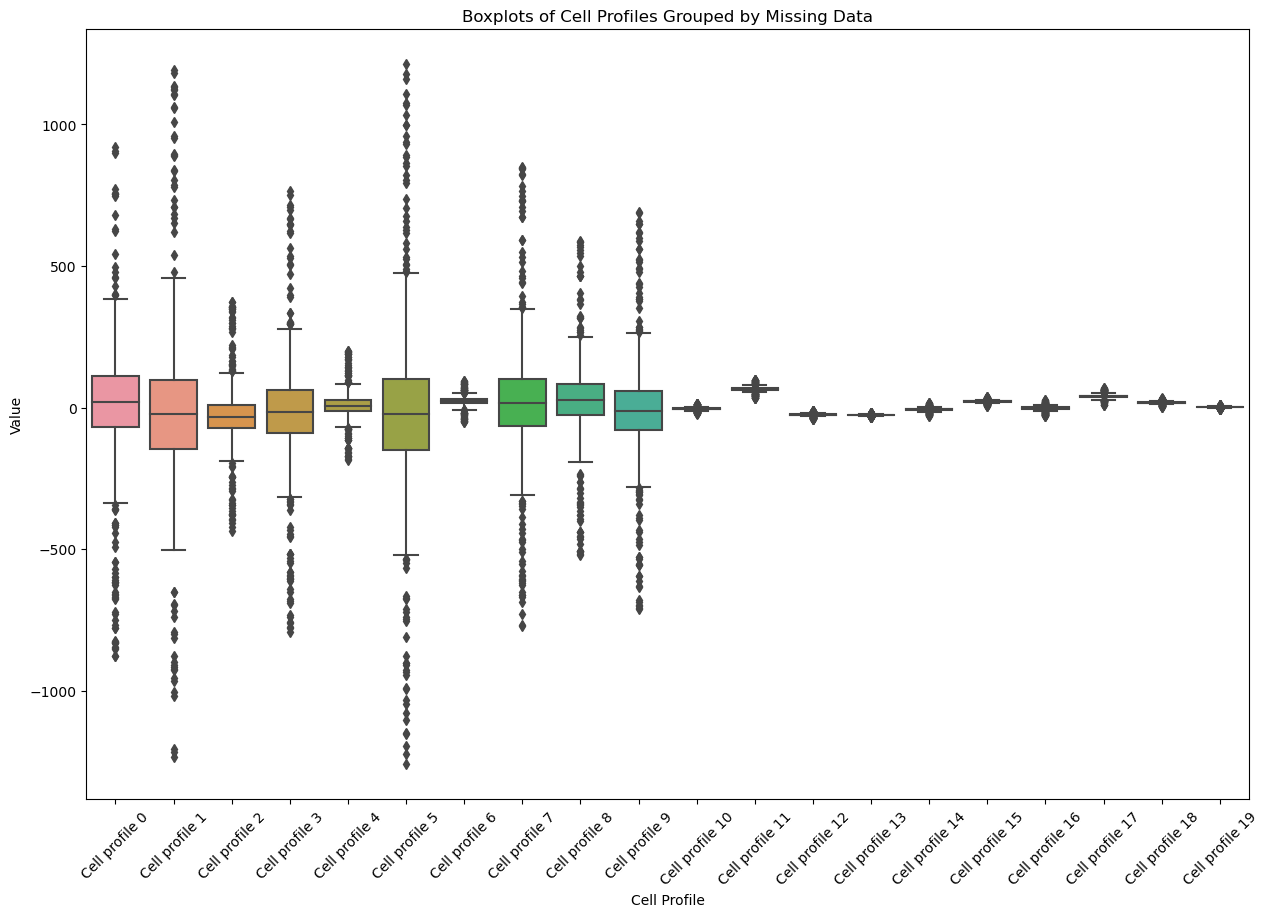

In [33]:
cell_profiles = [f"Cell profile {i}" for i in range(20)]
df_melted = pd.melt(dt, id_vars=['missing_data'], value_vars=cell_profiles)

# Create the boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(x='variable', y='value', data=df_melted)
plt.xticks(rotation=45)
plt.title('Boxplots of Cell Profiles Grouped by Missing Data')
plt.xlabel('Cell Profile')
plt.ylabel('Value')
plt.show()



Missing data

In [32]:
dt['missing_data'] = dt.isna().any(axis=1) # One hot encoding on the na

In [36]:
print(dt.columns[:-1])
# Convert 'Sex' and 'Racial group' to categorical
dt['Sex'] = dt['Sex'].astype('category')
dt['Racial group'] = dt['Racial group'].astype('category')

Index(['Age (years)', 'Sex', 'Racial group', 'Cell profile 0',
       'Cell profile 1', 'Cell profile 2', 'Cell profile 3', 'Cell profile 4',
       'Cell profile 5', 'Cell profile 6', 'Cell profile 7', 'Cell profile 8',
       'Cell profile 9', 'Cell profile 10', 'Cell profile 11',
       'Cell profile 12', 'Cell profile 13', 'Cell profile 14',
       'Cell profile 15', 'Cell profile 16', 'Cell profile 17',
       'Cell profile 18', 'Cell profile 19', 'Survival time (years)'],
      dtype='object')


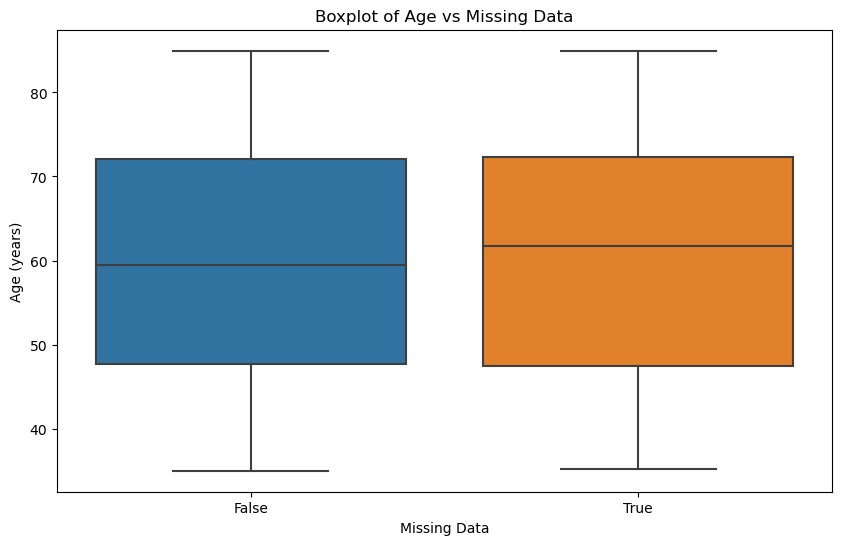

Sex           Female  Male  Total
Missing Data                     
False           1148  1030   2178
True             160   162    322
Total           1308  1192   2500


In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='missing_data', y='Age (years)', data=dt)

plt.title('Boxplot of Age vs Missing Data')
plt.xlabel('Missing Data')
plt.ylabel('Age (years)')
plt.show()

#
cross_tab = pd.crosstab(dt['missing_data'], dt['Sex'], margins=True, margins_name="Total")
cross_tab.index.name = "Missing Data"
cross_tab.columns.name = "Sex"
print(cross_tab)

Will just simple impute the data with the mean since only 25 are missing in some of the variables

In [34]:
# Identify truly numerical columns (int64 and float64 data types)
numerical_cols = dt.select_dtypes(include=['int64', 'float64']).columns

# Impute missing values in numerical columns with their mean  
dt[numerical_cols] = dt[numerical_cols].fillna(dt[numerical_cols].mean()) # IMPUTER



Handle outliers
Im just trying things out to see


In [9]:
#BELOW HERE IM JUST TRYING THINGS, AT THE END IM GOING TO LEAVE OUTLIERS, SINCE THEY LOOK LIKE OUTFLIERS
from scipy import stats
#Test DBscan for funskies
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dt[cell_profiles])

dbscan = DBSCAN(eps=5, min_samples=100)
clusters = dbscan.fit_predict(scaled_data)
outliers = (clusters == -1)
dt['is_outlier'] = outliers
print(dt['is_outlier'].sum())


#z scores

z_scores = np.abs((dt[cell_profiles] - dt[cell_profiles].mean()) / dt[cell_profiles].std())
outliers = (z_scores > 3).any(axis=1) # 3 is 95%
dt['is_outlier'] = outliers
dt['is_outlier'].value_counts()

def tukeys_fences(data, k=1.5):
    """
    Identify outliers using Tukey's fences.
    :param data: Input data (pandas Series).
    :param k: Coefficient (usually 1.5 or 3).
    :return: A boolean series where True indicates an outlier.
    """
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    return (data < lower_bound) | (data > upper_bound)

outlier_flags = pd.DataFrame()
for profile in cell_profiles:
    outlier_flags[profile + '_is_outlier'] = tukeys_fences(dt[profile], k=1.5)
outlier_counts = outlier_flags.sum()
print(outlier_counts)



64
Cell profile 0_is_outlier     66
Cell profile 1_is_outlier     52
Cell profile 2_is_outlier     66
Cell profile 3_is_outlier     67
Cell profile 4_is_outlier     60
Cell profile 5_is_outlier     69
Cell profile 6_is_outlier     60
Cell profile 7_is_outlier     67
Cell profile 8_is_outlier     59
Cell profile 9_is_outlier     68
Cell profile 10_is_outlier    65
Cell profile 11_is_outlier    67
Cell profile 12_is_outlier    59
Cell profile 13_is_outlier    58
Cell profile 14_is_outlier    69
Cell profile 15_is_outlier    66
Cell profile 16_is_outlier    64
Cell profile 17_is_outlier    65
Cell profile 18_is_outlier    59
Cell profile 19_is_outlier    68
dtype: int64


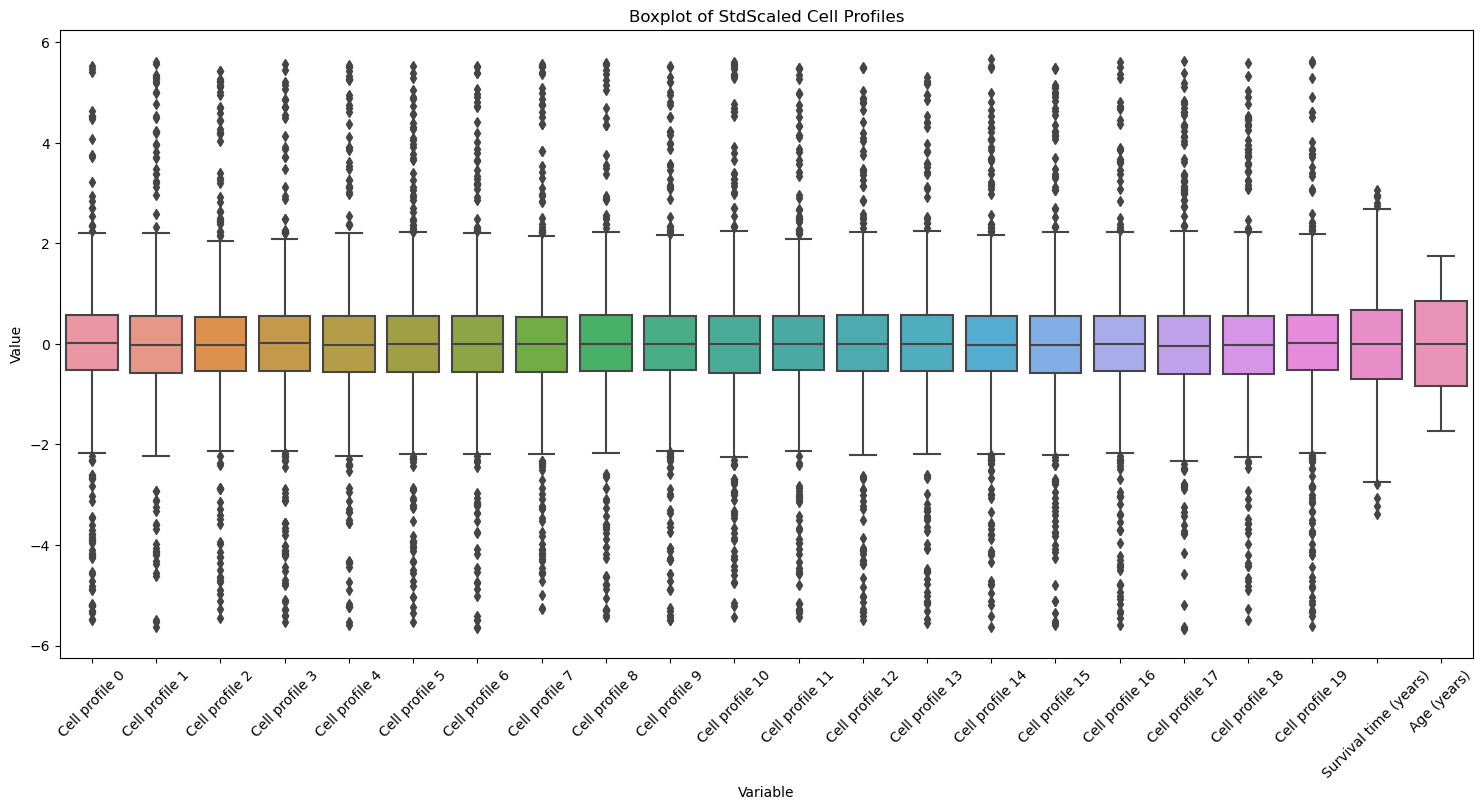

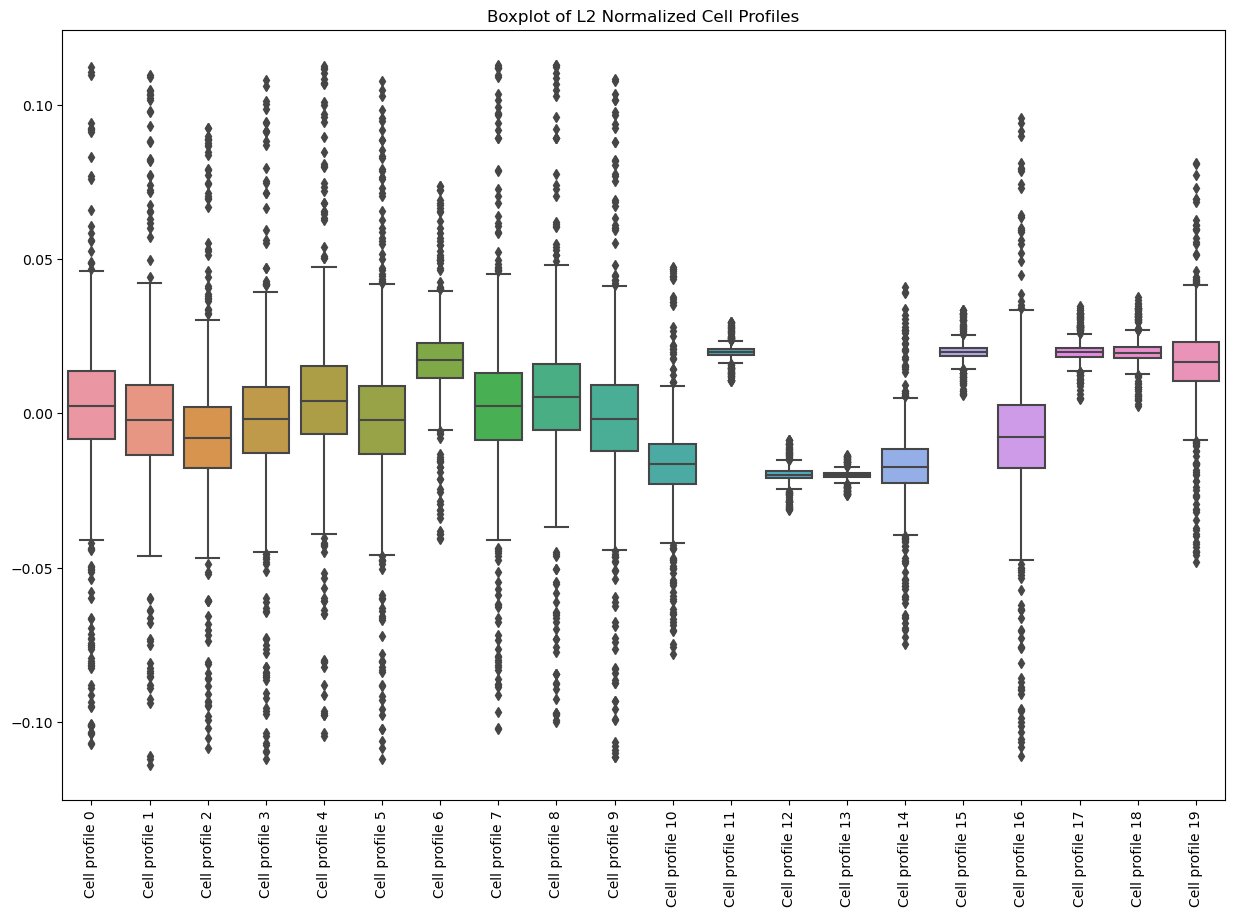

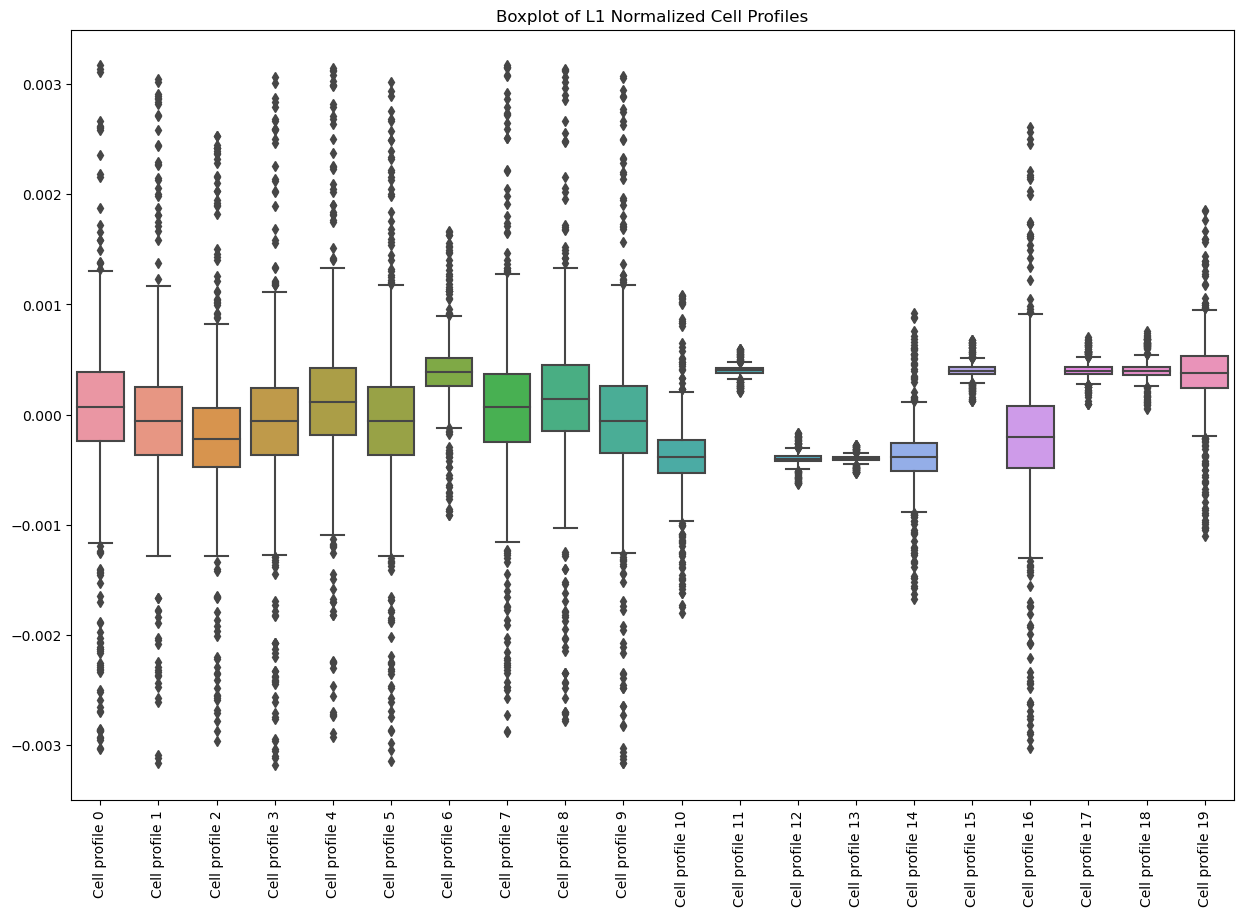

In [37]:
# Testing with normalization and scaling
# StandardScaler
selected_columns = cell_profiles + ['Survival time (years)','Age (years)'] 
# Scale using pandas
dt_scaled = dt[selected_columns].copy()  # Make a copy to ensure original data isn't modified
for col in selected_columns:
    dt_scaled[col] = (dt[col] - dt[col].mean()) / dt[col].std()

# Melt the DataFrame for Seaborn plotting
dt_melted = dt_scaled.melt(var_name='Variable', value_name='Value')

plt.figure(figsize=(15, 8))
sns.boxplot(x='Variable', y='Value', data=dt_melted)
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('Boxplot of StdScaled Cell Profiles')  # Add the title here
plt.show()




# Normalizer
# There is l2, l1 and max normalization
# Normalize the data using L2 norm 
dt_normalized = dt[cell_profiles].apply(lambda x: x / ((x**2).sum())**0.5, axis=0)


# Plot the boxplots using seaborn
plt.figure(figsize=(15, 10))
sns.boxplot(data=dt_normalized)
plt.xticks(rotation=90)
plt.title('Boxplot of L2 Normalized Cell Profiles')
plt.show()


# Normalize the data using L1 norm with pandas
dt_normalized_l1 = dt[cell_profiles].apply(lambda x: x / x.abs().sum(), axis=0)

# Plot the boxplots using seaborn
plt.figure(figsize=(15, 10))
sns.boxplot(data=dt_normalized_l1)
plt.xticks(rotation=90)
plt.title('Boxplot of L1 Normalized Cell Profiles')  # Title for L1 normalization
plt.show()

In [17]:
cell_profiles
dt

,Age (years),Sex,Racial group,Cell profile 0,Cell profile 1,Cell profile 2,Cell profile 3,Cell profile 4,Cell profile 5,Cell profile 6,...,Cell profile 13,Cell profile 14,Cell profile 15,Cell profile 16,Cell profile 17,Cell profile 18,Cell profile 19,Survival time (years),missing_data,is_outlier
0,68.475758,Female,Hispanic or Latino,-8.157101,-239.746069,-32.836253,-230.976922,-33.728470,-64.258003,22.956746,...,-20.617584,-12.444847,20.939882,6.009270,37.900230,17.272812,0.024656,11.508051,False,True
1,73.986450,Female,White,93.478737,-157.961018,14.631538,614.675436,-13.678756,-231.896554,29.752563,...,-27.363832,-4.045206,22.637911,2.613145,41.289307,18.726410,2.884620,9.522676,False,True
2,70.285954,Male,White,91.730740,-203.839995,-92.186941,-186.551883,-29.879525,-40.025009,26.173054,...,-26.268887,-4.757288,22.608706,0.150276,41.231022,17.960768,2.642166,8.472567,False,False
3,46.744625,Female,White,70.212764,-17.021044,-35.898403,83.209881,-107.864887,-116.057017,32.521885,...,-27.243317,-9.449100,22.249207,-5.450154,40.513496,19.318758,1.044667,5.196368,False,True
4,71.733703,Male,White,134.176720,9.179638,0.095330,57.317705,15.817103,-58.385986,24.084089,...,-27.913317,-9.928357,32.855518,-1.246710,42.646397,17.513947,0.881487,11.254032,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,63.689992,Female,Hispanic or Latino,250.058423,-56.084384,-14.716141,-29.002666,10.640480,-221.749835,13.893947,...,-25.395447,-7.986816,25.253883,0.762922,46.510506,15.334316,1.542555,13.273295,False,False
2496,78.736827,Female,White,-194.146015,-92.721610,-11.284786,-91.990486,32.927714,200.511723,10.503398,...,-26.653229,-1.041913,6.632689,8.827128,31.698372,14.609091,3.907200,15.344215,False,True
2497,37.484450,Female,Native Hawaiian or other Pacific Islander,-231.913901,161.369095,-10.737774,183.862521,-10.625946,-87.664727,4.800412,...,-27.578241,-7.591291,17.201582,-2.548019,63.714264,13.389245,1.677226,5.540625,False,True
2498,50.191400,Female,White,-93.543860,382.134743,-43.405837,-59.782287,9.528378,-274.671705,8.357999,...,-26.860096,-1.657178,19.513327,-6.885508,35.052982,14.150199,3.697711,10.616268,False,False


Multicollinearity adress



In [42]:
def check_multicollinearity(df):
    """
    Check multicollinearity of a dataframe using VIF.
    Processes only the continuous (numeric) columns.
    Returns a dataframe with columns and their respective VIF.
    """
    # Filtering the dataframe to include only numeric columns
    numeric_df = df.select_dtypes(include=['number'])
    
    # Adding a constant column for the intercept
    df_const = add_constant(numeric_df)
    
    # Calculating VIF for each column
    vifs = pd.Series(
        [variance_inflation_factor(df_const.values, i) 
         for i in range(df_const.shape[1])], 
        index=df_const.columns
    )
    
    return vifs



print(check_multicollinearity(dt))
print(check_multicollinearity(dt_scaled))


const                    1012.692639
Age (years)                 1.477224
Cell profile 0              1.999154
Cell profile 1              1.009201
Cell profile 2              1.680118
Cell profile 3              1.207666
Cell profile 4              1.910152
Cell profile 5              1.006449
Cell profile 6              1.657659
Cell profile 7              1.564652
Cell profile 8              1.948667
Cell profile 9              1.997536
Cell profile 10             2.132184
Cell profile 11             1.692554
Cell profile 12             2.003473
Cell profile 13             1.925302
Cell profile 14             1.989552
Cell profile 15             2.059095
Cell profile 16             1.564041
Cell profile 17             2.138917
Cell profile 18             1.659189
Cell profile 19             1.987764
Survival time (years)       2.884032
dtype: float64
const                    1.000000
Cell profile 0           1.999154
Cell profile 1           1.009201
Cell profile 2           1.68011

In [45]:
dt_scaled['Racial group'] = dt['Racial group']
dt_scaled['Sex'] = dt['Sex']

In [47]:
print(dt)
print(dt_scaled)
print(dt.columns)
print(dt_scaled.columns)

      Age (years)     Sex                               Racial group   
0       68.475758  Female                         Hispanic or Latino  \
1       73.986450  Female                                      White   
2       70.285954    Male                                      White   
3       46.744625  Female                                      White   
4       71.733703    Male                                      White   
...           ...     ...                                        ...   
2495    63.689992  Female                         Hispanic or Latino   
2496    78.736827  Female                                      White   
2497    37.484450  Female  Native Hawaiian or other Pacific Islander   
2498    50.191400  Female                                      White   
2499    65.173755    Male                                      White   

      Cell profile 0  Cell profile 1  Cell profile 2  Cell profile 3   
0          -8.157101     -239.746069      -32.836253     -230.9

In [48]:
df_encoded = pd.get_dummies(dt_scaled, columns=['Racial group'], drop_first=True) # drop_first avoids multicollinearity


In [57]:
df_encoded.columns

Index(['Cell profile 0', 'Cell profile 1', 'Cell profile 2', 'Cell profile 3',
       'Cell profile 4', 'Cell profile 5', 'Cell profile 6', 'Cell profile 7',
       'Cell profile 8', 'Cell profile 9', 'Cell profile 10',
       'Cell profile 11', 'Cell profile 12', 'Cell profile 13',
       'Cell profile 14', 'Cell profile 15', 'Cell profile 16',
       'Cell profile 17', 'Cell profile 18', 'Cell profile 19',
       'Survival time (years)', 'Age (years)', 'Sex', 'Racial group_Asian',
       'Racial group_Black or African American',
       'Racial group_Hispanic or Latino',
       'Racial group_Native Hawaiian or other Pacific Islander',
       'Racial group_White'],
      dtype='object')

In [56]:
# Define the function to fit
def func(x, *params):
    # x is a tuple containing data for all features
    # params will contain the coefficients for each feature
    
    # Calculate the linear combination of the data and the coefficients
    y = np.zeros_like(x[0])  # Initialize y to zeros of same shape as one of the features
    for i in range(len(params)):
        y += params[i] * x[i]
    return y

# List of continuous features
features = ['Cell profile ' + str(i) for i in range(20)] + ['Age (years)']

# Add the one-hot encoded racial group columns to the features list
racial_columns = [col for col in df_encoded.columns if 'Racial group' in col]
features += racial_columns

# Split data into x (features) and y (target)
x_data = tuple(df_encoded[feature].values for feature in features)
y_data = df_encoded['Survival time (years)'].values

initial_guess = [1] * len(features)

# Fit the function using curve_fit
params, covariance = sp.optimize.curve_fit(func, x_data, y_data, p0=initial_guess)


print("Parameters:", params)
for feature, coef in zip(features, params):
    print(f"{feature}: {coef}")

Parameters: [ 0.00725587 -0.01192405  0.16297572 -0.26534451  0.56016859  0.00914079
  0.00418763 -0.03111016  0.00074279 -0.01894235  0.02141642  0.17482476
  0.00109489 -0.00789527 -0.02578633  0.01964405  0.02985877 -0.03399702
 -0.00540499  0.03194174  0.39955773  0.14443714  0.1151004   0.1240757
  0.09311784 -0.20630599]
Cell profile 0: 0.007255871199729813
Cell profile 1: -0.01192404667796243
Cell profile 2: 0.16297572345824418
Cell profile 3: -0.2653445087724444
Cell profile 4: 0.5601685859405248
Cell profile 5: 0.009140786461712458
Cell profile 6: 0.004187631893161181
Cell profile 7: -0.031110163949524372
Cell profile 8: 0.0007427880160170153
Cell profile 9: -0.01894234658929661
Cell profile 10: 0.021416418516895908
Cell profile 11: 0.17482476467881303
Cell profile 12: 0.0010948910628830744
Cell profile 13: -0.007895270299885349
Cell profile 14: -0.02578632866471975
Cell profile 15: 0.01964405120504431
Cell profile 16: 0.029858773985816933
Cell profile 17: -0.03399701787129960

In [59]:
def func(x, intercept, *params):
    # x is a tuple containing data for all features
    # params will contain the coefficients for each feature
    # intercept is the model's intercept
    
    # Initialize y with the intercept
    y = np.full_like(x[0], intercept)  # Initialize y to the intercept with same shape as one of the features
    
    for i in range(len(params)):
        y += params[i] * x[i]
    return y

# List of continuous features
features = ['Cell profile ' + str(i) for i in range(20)] + ['Age (years)']

# Add the one-hot encoded racial group columns to the features list
racial_columns = [col for col in df_encoded.columns if 'Racial group' in col]
features += racial_columns

# Split data into x (features) and y (target)
x_data = tuple(df_encoded[feature].values for feature in features)
y_data = df_encoded['Survival time (years)'].values

initial_guess = [1] * (len(features) + 1) 

# Fit the function using curve_fit
params, covariance = sp.optimize.curve_fit(func, x_data, y_data, p0=initial_guess)


print("Parameters:", params)
for feature, coef in zip(features, params):
    print(f"{feature}: {coef}")

Parameters: [ 0.09914649  0.00784453 -0.01172174  0.16424922 -0.26579913  0.56123005
  0.00806332  0.00316617 -0.0305475   0.00125896 -0.01813985  0.02144934
  0.1735944  -0.00210055 -0.00592681 -0.02491466  0.02000481  0.03023213
 -0.03471464 -0.00405796  0.03168822  0.3997631   0.04492329  0.01578886
  0.02488773 -0.00644722 -0.30559364]
Cell profile 0: 0.09914649136596576
Cell profile 1: 0.007844531077764061
Cell profile 2: -0.011721742890730358
Cell profile 3: 0.16424922177889745
Cell profile 4: -0.2657991267697626
Cell profile 5: 0.5612300461360261
Cell profile 6: 0.008063317785560242
Cell profile 7: 0.0031661710482240313
Cell profile 8: -0.030547503221211914
Cell profile 9: 0.0012589586903324346
Cell profile 10: -0.018139846488984812
Cell profile 11: 0.02144934353907213
Cell profile 12: 0.1735943992836515
Cell profile 13: -0.0021005506827895815
Cell profile 14: -0.0059268145197186595
Cell profile 15: -0.02491466054005631
Cell profile 16: 0.020004813616609995
Cell profile 17: 0.03

In [61]:
# Extract the intercept from the params and then use the rest for the features
intercept = params[0]
equation = f"Survival time (years) = {intercept:.5f} + "

for feature, coef in zip(features, params[1:]):  # Starting from the second parameter, since we extracted the intercept
    equation += f"{coef:.5f} * {feature} + "

# Remove the last "+"
equation = equation[:-2]

print(equation)


Survival time (years) = 0.09915 + 0.00784 * Cell profile 0 + -0.01172 * Cell profile 1 + 0.16425 * Cell profile 2 + -0.26580 * Cell profile 3 + 0.56123 * Cell profile 4 + 0.00806 * Cell profile 5 + 0.00317 * Cell profile 6 + -0.03055 * Cell profile 7 + 0.00126 * Cell profile 8 + -0.01814 * Cell profile 9 + 0.02145 * Cell profile 10 + 0.17359 * Cell profile 11 + -0.00210 * Cell profile 12 + -0.00593 * Cell profile 13 + -0.02491 * Cell profile 14 + 0.02000 * Cell profile 15 + 0.03023 * Cell profile 16 + -0.03471 * Cell profile 17 + -0.00406 * Cell profile 18 + 0.03169 * Cell profile 19 + 0.39976 * Age (years) + 0.04492 * Racial group_Asian + 0.01579 * Racial group_Black or African American + 0.02489 * Racial group_Hispanic or Latino + -0.00645 * Racial group_Native Hawaiian or other Pacific Islander + -0.30559 * Racial group_White 


Bland-Altman Plot:

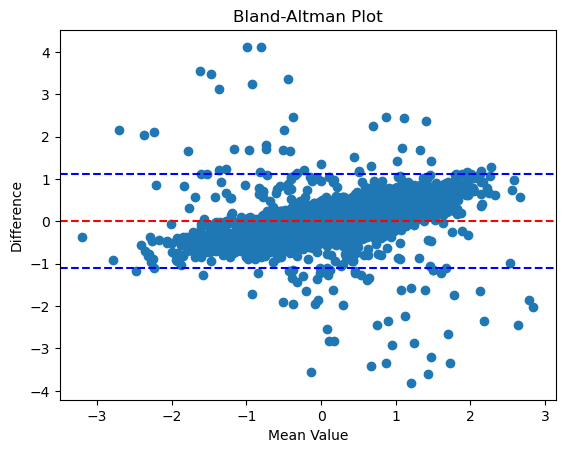

In [65]:
predictions = func(x_data, *params)
residuals = y_data - predictions
mean_vals = (y_data + predictions) / 2
differences = y_data - predictions

plt.scatter(mean_vals, differences)
plt.axhline(0, color='red', linestyle='--')  # line at zero difference
plt.axhline(differences.mean() + 1.96*differences.std(), color='blue', linestyle='--') # Upper 95% limit
plt.axhline(differences.mean() - 1.96*differences.std(), color='blue', linestyle='--') # Lower 95% limit
plt.title('Bland-Altman Plot')
plt.xlabel('Mean Value')
plt.ylabel('Difference')
plt.show()

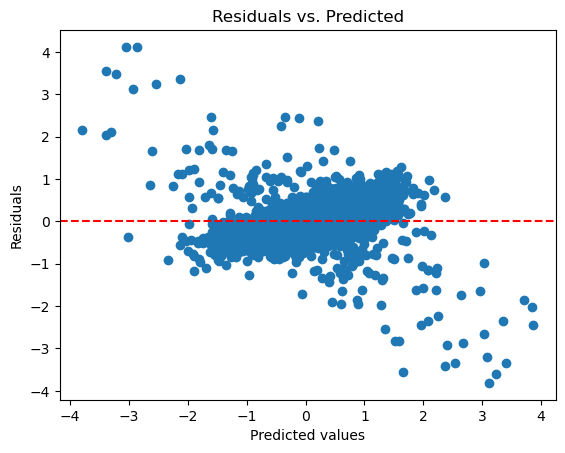

In [66]:
plt.scatter(predictions, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

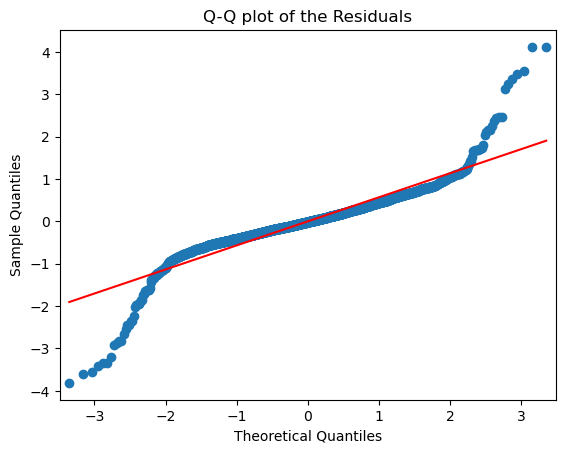

In [68]:
import statsmodels.api as sm
sm.qqplot(residuals, line='s')
plt.title('Q-Q plot of the Residuals')
plt.show()

In [ ]:
# 3. Plot residuals against each predictor
for i, feature in enumerate(features):
    plt.figure(figsize=(10, 6))
    plt.scatter(x_data[i], residuals, alpha=0.5)
    plt.title(f'Residuals vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference
    plt.show()

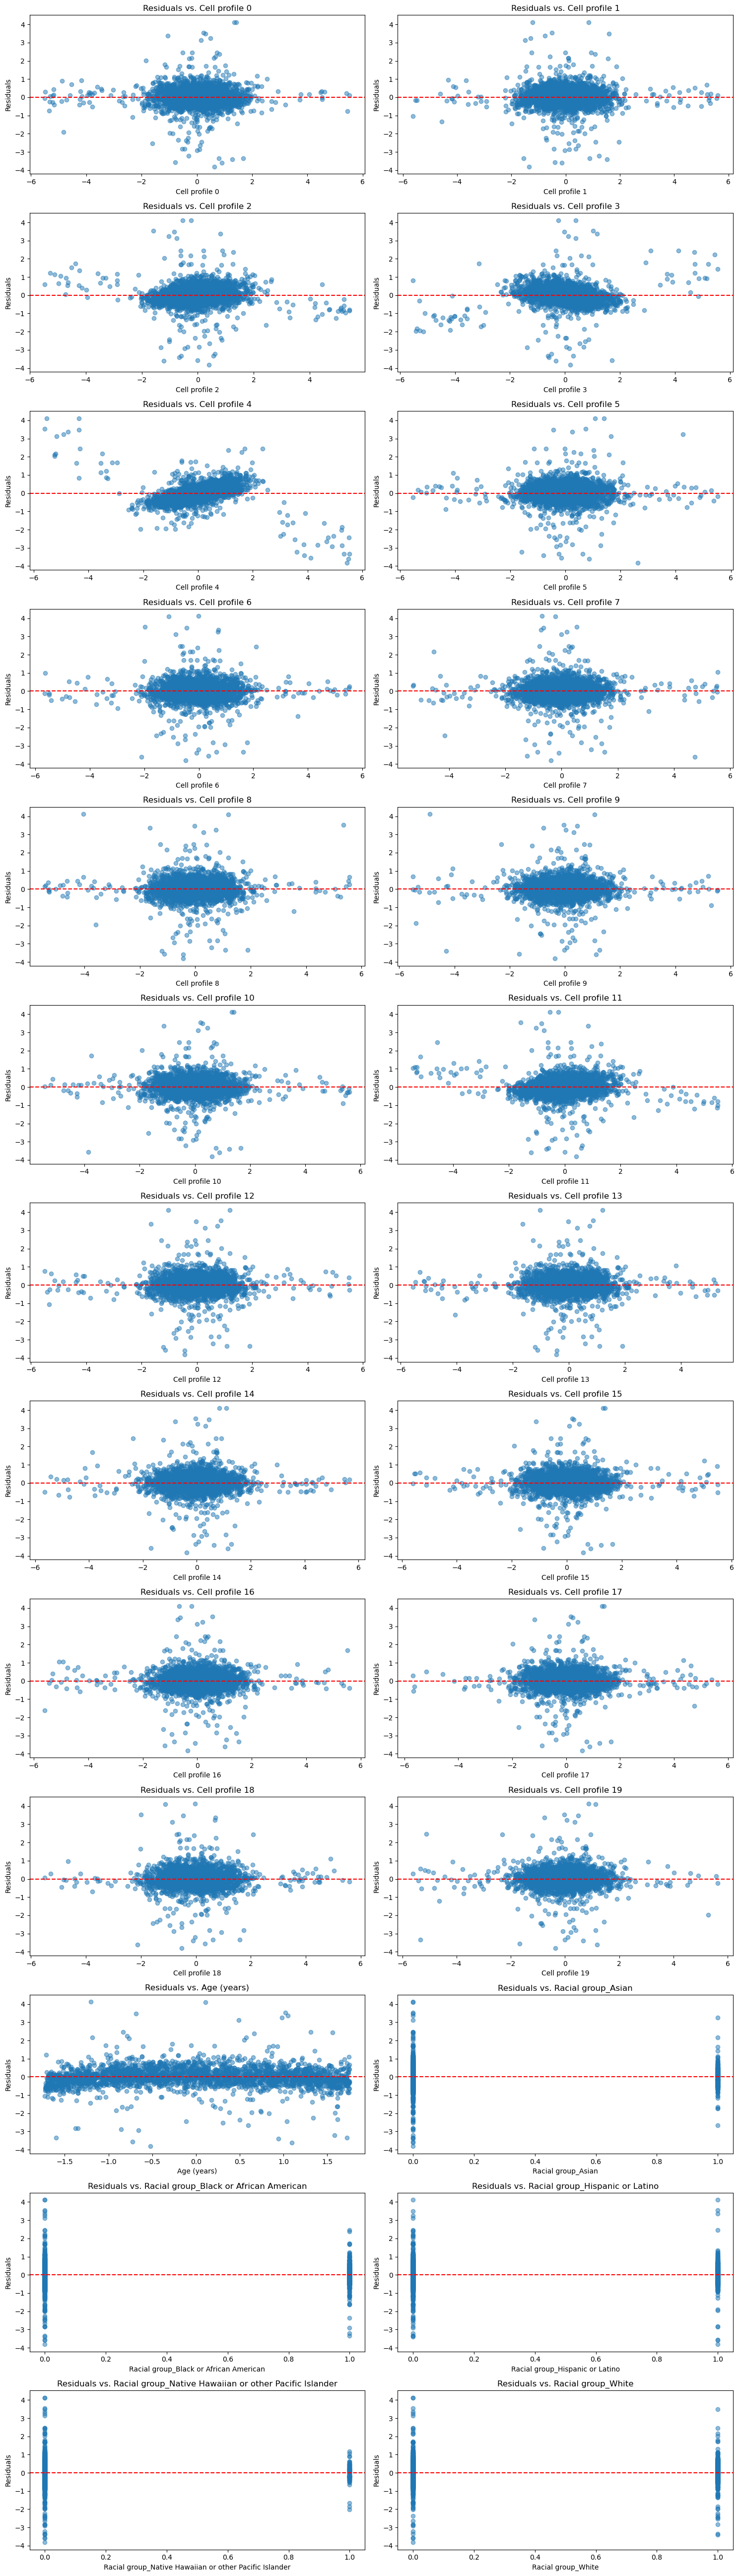

In [70]:
n_features = len(features)
n_rows = int(np.ceil(n_features / 2))

fig, axes = plt.subplots(n_rows, 2, figsize=(15, 4 * n_rows))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    
    ax.scatter(x_data[i], residuals, alpha=0.5)
    ax.set_title(f'Residuals vs. {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Residuals')
    ax.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0 for reference

# If there's an odd number of features, remove the last empty plot
if n_features % 2:
    fig.delaxes(axes[row, 1])

plt.tight_layout()
plt.show()

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import bartlett

# Predicted values using the optimized parameters
predicted_values = func(x_data, *params)

# Calculate residuals
residuals = y_data - predicted_values

#R-squared and Adjusted R-squared
SS_res = np.sum(residuals**2)
SS_tot = np.sum((y_data - np.mean(y_data))**2)
R2 = 1 - (SS_res / SS_tot)

n = len(y_data)
p = len(features)
Adj_R2 = 1 - (1-R2)*(n-1)/(n-p-1)


# For a formal test for homoscedasticity
test_statistic, p_value = bartlett(predicted_values, residuals)
if p_value < 0.05:
    print("There might be heteroscedasticity present as per Bartlett's test.")
else:
    print("Residuals seem to have constant variance as per Bartlett's test.")

#RMSE
RMSE = np.sqrt(mean_squared_error(y_data, predicted_values))

print(f"R-squared: {R2:.4f}")
print(f"Adjusted R-squared: {Adj_R2:.4f}")
print(f"RMSE: {RMSE:.4f}")


There might be heteroscedasticity present as per Bartlett's test.
R-squared: 0.6774
Adjusted R-squared: 0.6740
RMSE: 0.5678
